## Quality Processes for Images

In [1]:
# Importing useful dependencies
import io
import os
import boto3
from PIL import Image

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Setup S3 client for MinIO (MinIO implements Amazon S3 API)
s3 = boto3.client(
    "s3",
    endpoint_url="http://127.0.0.1:9000", # MinIO API endpoint
    aws_access_key_id="minioadmin", # User name
    aws_secret_access_key="minioadmin", # Password
)

Before preparing/cleaning the data for exploitation zone, we have to perform a quality analysis of the images stored in the Trusted Zone (Copied from the Formatted Zone). For that purpose, firstly we are going to extract data from each of our images.

In [4]:
# Given a bucket and a prefix, the function returns a list of data of each image in the target path
def get_data_images(bucket, prefix=""):

    data = []
    
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get("Contents", []):
            
            key = obj["Key"]

            if obj['Size'] == 0 and key.endswith("/"): # skip the folder itself
                continue

            # Download the image
            resp = s3.get_object(Bucket=bucket, Key=key)
            body = resp["Body"].read()
        
            with Image.open(io.BytesIO(body)) as img:
                width, height = img.size
                mode = img.mode
                n_channels = len(mode) if mode in ["RGB","RGBA","L","CMYK"] else None
        
            data.append({
                "file_name": key,
                "file_size": obj['Size'] / 1024, # B -> KB
                "width": width,
                "height": height,
                "aspect_ratio": round(width/height, 2) if height > 0 else None, # proportional relationship between image width and height
                "mode": mode, # how pixel values are stored
                "channels": n_channels # number of color channels in the image
            })

    return data

In [5]:
# Get data from the bucket
data = get_data_images(bucket = "trusted-zone", prefix = "images")

In [6]:
# Convert the data into a dataFrame
df_data = pd.DataFrame(data)
df_data.head()

,file_name,file_size,width,height,aspect_ratio,mode,channels
0,images/image_1759415197916.png,209.694336,460,215,2.14,RGB,3
1,images/image_1759415198090.png,165.176758,460,215,2.14,RGB,3
2,images/image_1759415198272.png,184.975586,460,215,2.14,RGB,3
3,images/image_1759415198417.png,19.867188,460,215,2.14,RGB,3
4,images/image_1759415198540.png,84.223633,460,215,2.14,RGB,3


In [7]:
# Have a quick summary of the data
df_data.describe(include="all")

,file_name,file_size,width,height,aspect_ratio,mode,channels
count,600,600.000000,600.000000,600.000000,600.000000,600,600.000000
unique,600,NaN,NaN,NaN,NaN,2,NaN
top,images/image_1759415197916.png,NaN,NaN,NaN,NaN,RGB,NaN
freq,1,NaN,NaN,NaN,NaN,599,NaN
mean,NaN,1823.476709,1322.078333,743.973333,1.943383,NaN,2.996667
std,NaN,4666.023140,1136.986485,714.919069,0.253340,NaN,0.081650
min,NaN,10.204102,460.000000,215.000000,0.890000,NaN,1.000000
25%,NaN,149.793457,460.000000,215.000000,1.780000,NaN,3.000000
50%,NaN,224.229004,528.500000,257.500000,2.140000,NaN,3.000000
75%,NaN,2188.601807,1920.000000,1080.000000,2.140000,NaN,3.000000


In [8]:
# Unique values for mode
pd.unique(df_data['mode'])

array(['RGB', 'L'], dtype=object)

Looking at the table shown above, the images we have are around 2MB (mean/1024) in size. In fact, the first 75% of the data are around that size. However, then we have that the maximum file size is around 100MB. On the other hand, we have different distributions in both width and height columns, which suggests the images are not square and this implies varied aspect ratio for the images. When it comes to the mode, the most of our images are RGB (3 channels) and the remaining ones are L (8-bit grayscale image).

Next, we show some plots to better illustrate the characteristics of our images.

**Distribution of File Sizes**

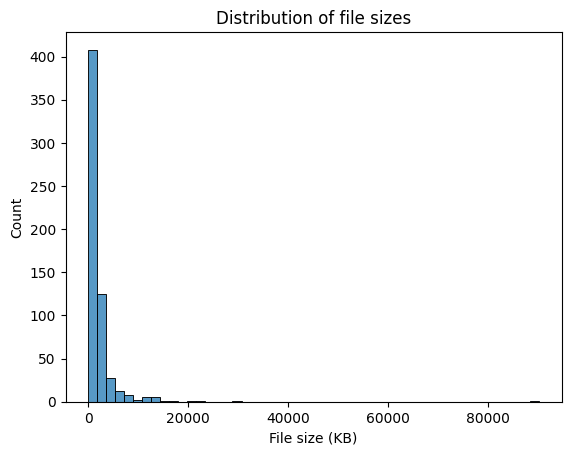

In [12]:
sns.histplot(df_data["file_size"], bins=50)
plt.xlabel("File size (KB)")
plt.ylabel("Count")
plt.title("Distribution of file sizes")
plt.show()

Most images are small, around 1MB (1024KB). But there are some outliers like the ones that are around 40000KB and 100000KB.

**Width vs Height of Images**

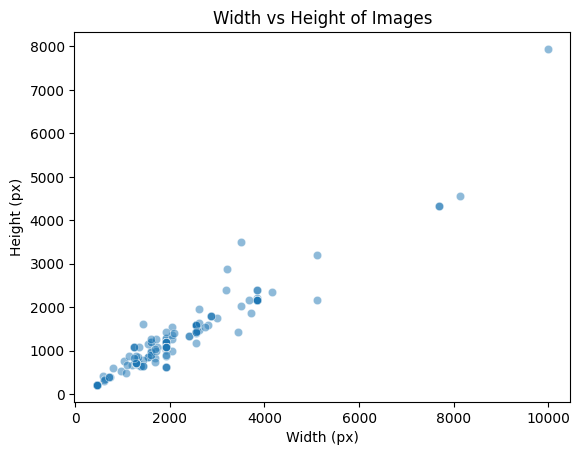

In [13]:
sns.scatterplot(x="width", y="height", data=df_data, alpha=0.5)
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Width vs Height of Images")
plt.show()

Like we mentioned before, there are some outliers, big images that exceed the rest of the images, in our dataset.

**Aspect Ratio Distribution**

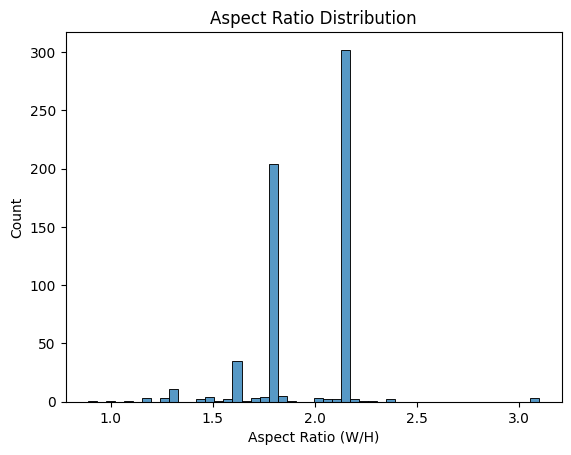

In [14]:
sns.histplot(df_data["aspect_ratio"].dropna(), bins=50)
plt.xlabel("Aspect Ratio (W/H)")
plt.title("Aspect Ratio Distribution")
plt.show()

Here, we provide another perspective to analyze the size of the images. The aspect ratio is computed by dividing the width by the height of an image. This metric does not directly measure the file size, but rather the shape and proportions of the image.

Most of the images have an aspect ratio around 2, which suggests that they are approximately twice as wide as they are tall. In other words, the dataset is dominated by horizontally oriented (landscape) images.

**Data Cleaning**

As observed in the previous quality analysis, most of our images are already in RGB format (3 channels). Although it is possible to convert them into RGBA (4 channels), doing so would introduce unnecessary complexity without providing any real benefit for our use case. Since these images will later be converted into embeddings, it is more practical to keep them in RGB (3 channels). This approach ensures consistency across the dataset, avoids the overhead of an unused alpha channel, and aligns with the input requirements of most machine learning models.

On the other hand, we want to normalize the images to a fixed resolution, for example 512×512. This ensures uniformity across the dataset, making the embeddings more consistent and comparable, and also optimizes processing efficiency when generating vectors. While we considered removing outliers from the dataset, we preferred to retain all images to preserve the full diversity of the collection. Instead, we decided to handle variations through preprocessing adjustments. After resizing, we can also normalize the pixel values by converting them to a standard range, which helps stabilize the model’s input, improves convergence, and ensures that differences in lighting or color intensity do not disproportionately affect the embeddings.

In [31]:
def preprocess_image(bucket, prefix="", target_size=(512, 512)):
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get("Contents", []):

            key = obj["Key"]

            if obj['Size'] == 0 and key.endswith("/"): # skip the folder itself
                continue
            
            # Get object metadata to check size
            head = s3.head_object(Bucket=bucket, Key=key)
            if head['ContentLength'] == 0:
                # Delete the null image (size = 0)
                s3.delete_object(Bucket=bucket, Key=key)
                continue

            # Download the image
            resp = s3.get_object(Bucket=bucket, Key=key)
            body = resp["Body"].read()
            
            # Load image with Pillow
            img = Image.open(io.BytesIO(body))
            
            # Convert images into RGB
            if img.mode != 'RGB':
                img = img.convert('RGB') # 3 channels
            
            # Resize image
            img = img.resize(target_size, Image.LANCZOS) # Image.LANCZOS = image smoother
            
            # Convert to numpy array and normalize pixel values to [0, 1]
            img_array = np.array(img).astype(np.float32) / 255.0
            # Convert back to PIL Image
            img_out = Image.fromarray((img_array * 255).astype(np.uint8))
            buf = io.BytesIO()
            img_out.save(buf, format="PNG")
            buf.seek(0)
            
            # Upload the image back
            s3.upload_fileobj(buf, Bucket=bucket, Key=key, ExtraArgs={"ContentType": "image/png"}) # the old file is overwritten with the new one

            print(f"Normalized: {key}")

In [30]:
# Standardizing images
preprocess_image(bucket = "trusted-zone", prefix = "images/", target_size = (512,512))

Normalized: images/image_1759415197916.png
Normalized: images/image_1759415198090.png
Normalized: images/image_1759415198272.png
Normalized: images/image_1759415198417.png
Normalized: images/image_1759415198540.png
Normalized: images/image_1759415198675.png
Normalized: images/image_1759415198801.png
Normalized: images/image_1759415198932.png
Normalized: images/image_1759415199061.png
Normalized: images/image_1759415199214.png
Normalized: images/image_1759415199336.png
Normalized: images/image_1759415199478.png
Normalized: images/image_1759415199604.png
Normalized: images/image_1759415199737.png
Normalized: images/image_1759415199869.png
Normalized: images/image_1759415200018.png
Normalized: images/image_1759415200154.png
Normalized: images/image_1759415200289.png
Normalized: images/image_1759415200415.png
Normalized: images/image_1759415200552.png
Normalized: images/image_1759415200673.png
Normalized: images/image_1759415200842.png
Normalized: images/image_1759415200967.png
Normalized:

In [32]:
# Get data from the bucket
norm_data = get_data_images(bucket = "trusted-zone", prefix = "images")
# Convert the data into a dataFrame
df_norm_data = pd.DataFrame(norm_data)
df_norm_data.head()
# Have a quick summary of the data
df_norm_data.describe(include="all")

,file_name,file_size,width,height,aspect_ratio,mode,channels
count,600,600.000000,600.0,600.0,600.0,600,600.0
unique,600,NaN,NaN,NaN,NaN,1,NaN
top,images/image_1759415197916.png,NaN,NaN,NaN,NaN,RGB,NaN
freq,1,NaN,NaN,NaN,NaN,600,NaN
mean,NaN,340.606045,512.0,512.0,1.0,NaN,3.0
std,NaN,109.302704,0.0,0.0,0.0,NaN,0.0
min,NaN,17.915039,512.0,512.0,1.0,NaN,3.0
25%,NaN,269.306641,512.0,512.0,1.0,NaN,3.0
50%,NaN,352.122070,512.0,512.0,1.0,NaN,3.0
75%,NaN,422.853271,512.0,512.0,1.0,NaN,3.0
